In [4]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径
import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\\MPC\高炉")




In [5]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\new\\Si.xlsx'
df_Si = pd.read_excel(excel_path) 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='剔除直线输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='单SI_0.2_0.8') 
print(df_Si.info())
print(df_Si.columns)

excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\new\\间隔1min平均.xlsx'
df_params = pd.read_excel(excel_path) 

print(df_params.info())
print(df_params.columns)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   主参数时间戳      2525 non-null   datetime64[ns]
 1   Unnamed: 1  0 non-null      float64       
 2   Unnamed: 2  0 non-null      float64       
 3   Unnamed: 3  0 non-null      float64       
 4   SI          2525 non-null   float64       
 5   Unnamed: 5  0 non-null      float64       
 6   Unnamed: 6  0 non-null      float64       
 7   Unnamed: 7  0 non-null      float64       
 8   min         2525 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 177.7 KB
None
Index(['主参数时间戳', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'SI', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'min'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55139 entries, 0 to 55138
Data columns (total 38 columns):
 #   Column    Non-Null Count  Dtype         
-

In [8]:
# 定义输入输出参数     '富氧流量', '冷风流量', '热风压力', '冷风压力', '热风压力', '热风温度', '鼓风湿度', '设定喷煤量' ////// ['富氧流量', '冷风流量', '热风温度', '设定喷煤量']
input_term =  ['富氧流量', '设定喷煤量', '热风压力', '冷风温度','冷风流量', '冷风压力','鼓风湿度','热风温度']
output_term = ['SI']
time_term= 'min'


In [9]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_params[input_term[0]].values,
    input_term[1]:   df_params[input_term[1]].values,
    input_term[2]:   df_params[input_term[2]].values,
    input_term[3]:   df_params[input_term[3]].values,
    input_term[4]:   df_params[input_term[0]].values,
    input_term[5]:   df_params[input_term[1]].values,
    input_term[6]:   df_params[input_term[2]].values,
    input_term[7]:   df_params[input_term[3]].values,
    # input_term[4]:   df_sheet_params_process[input_term[4]].values,
    # input_term[5]:   df_sheet_params_process[input_term[5]].values,
    # input_term[6]:   df_sheet_params_process[input_term[6]].values,
    output_term[0]:  df_Si[output_term[0]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [89]:
# isShuffle = True
isShuffle= False
time_steps = 1
test_size = 0.15
val_size = 0.15
train_size = 1-val_size-test_size


In [90]:
# 组合训练数据--拆分训练、测试集

# 定义时间步数和特征数

# 构成    
# X = [X(t),X(t-1),Y(t-1)]
# Y = [Y(t)]
def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,u8_data,y1_data):
    X = np.column_stack((u1_data,u2_data,u3_data,u4_data))
    y = y1_data

    X_modified = []
    y_modified = []
    
    for i in range(400,840):
        
        print(i)
        # print(df_Si[time_term][i])
        yuansu_time = df_Si[time_term][i]
        closest_10 = df_params[df_params[time_term] <= yuansu_time].nlargest(time_steps, time_term)
        # print(closest_10)
        
        index = closest_10.index
        # print(index)
        # print(closest_10.iloc[-1][time_term])


        # print(X[index, :])
        new_x_sample = np.concatenate([X[i, :] for i in index],axis=0)
        # print(new_x_sample)
        
        y_sample = y[i]  
        X_modified.append(new_x_sample)
        y_modified.append(y_sample)
        # print(i,yuansu_time,index[0],index[-1], end='\r')
        # break

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)
    X_reshaped = X_modified.reshape((X_modified.shape[0], X_modified.shape[1]))

    # 打印新数据的形状
    print("Modified Input Shape:", X_reshaped.shape)
    print("Modified Output Shape:", y_modified.shape)


    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [91]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
u8_data = normalized_data_dict[input_term[7]]
y1_data = normalized_data_dict[output_term[0]]
num_samples = y1_data.shape[0]

# filter_windows = 2
# u1_data = symmetrical_moving_average(u1_data, filter_windows)
# u2_data = symmetrical_moving_average(u2_data, filter_windows)
# u3_data = symmetrical_moving_average(u3_data, filter_windows)
# u4_data = symmetrical_moving_average(u4_data, filter_windows)
# u5_data = symmetrical_moving_average(u5_data, filter_windows)
# u6_data = symmetrical_moving_average(u6_data, filter_windows)
# u7_data = symmetrical_moving_average(u7_data, filter_windows)
# y1_data = symmetrical_moving_average(y1_data, filter_windows)
# y2_data = symmetrical_moving_average(y2_data, filter_windows)

print('高炉模型数据')
X__train, X__val, X__test,\
y__train, y__val, y__test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,u8_data,
                                                            y1_data)


高炉模型数据
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
6

In [92]:
epoch_once_time = 100
ischuangxin = True
ischuangxin = False


In [93]:
# 定义模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x0):
        if ischuangxin:
            
            x = self.fc1(x0)
            x = self.relu(x)
            x2 = x0+x
            x3 = self.fc2(x2)
        else:
            x = self.fc1(x0)
            x = self.relu(x)
            x3 = self.fc2(x)

        return x3
    
    # def __init__(self, input_size, hidden_size, output_size):
    #     super(MyNeuralNetwork, self).__init__()
    #     self.relu = nn.ReLU()
    #     self.fc1 = nn.Linear(input_size, hidden_size)
    #     self.fc2 = nn.Linear(hidden_size+input_size, hidden_size)
    #     self.fc3 = nn.Linear(hidden_size*2+input_size, output_size)
    #     self.fc4 = nn.Linear(hidden_size+hidden_size+input_size, output_size)

    # def forward(self, x0):
    #     x1 = self.fc1(x0)#[input_size]
    #     x1 = self.relu(x1)#[hidden_size]

    #     x2 = torch.cat([x0, x1], dim=1) #[hidden_size+input_size]
    #     x2 = self.fc2(x2)
    #     x2 = self.relu(x2)#[hidden_size]

    #     x3 = torch.cat([x0, x1, x2], dim=1) #[hidden_size*2+input_size]
    #     x4 = self.fc3(x3)#[hidden_size]

    #     return x4  # 这里不应用任何激活函数4

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse



    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_val) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred.detach().numpy()


In [94]:
# 建立高炉模型实例
input_size = X__train.shape[1]  # 输入特征大小
hidden_size = 128  # 32
output_size = 1  # 输出大小
# 设置随机种子
torch.manual_seed(0)
model_ = MyNeuralNetwork(input_size, hidden_size, output_size)
epoch_sum_ = 0
_train_loss_list = []
_val_loss_list = []


第 100/100 轮, 训练误差: 0.3518, 验证误差: 0.4470
epoch_sum: 100


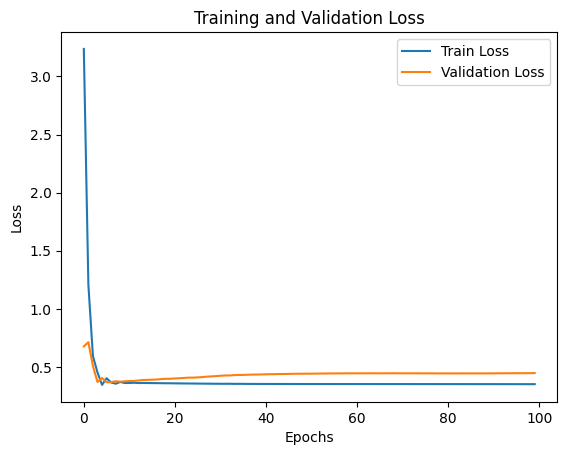

In [95]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_ = epoch_sum_ + epoch_once
_train_loss_list,_val_loss_list = model_.my_fit(X__train, y__train,
                                    X__val, y__val, 
                                    _train_loss_list, _val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=32,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_)

# 绘制训练和验证损失曲线
plt.plot(_train_loss_list, label='Train Loss')
plt.plot(_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [98]:
def huahua (scalers,  output_term,y_pred_0,y_test):
        
    y_test_0 = scalers[output_term[0]].inverse_transform((y_test).reshape(-1, 1)).flatten()
    y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()

    rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))

    # 计算 
    mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))


    mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100

    percent0 = np.sum(np.fabs(y_test_0 - y_pred_0_inverse_transform) < 0.1)/len(y_test_0)
    # 打印结果

    print(f"RMSE:  {output_term[0]}: {rmse_0:.4f}")
    print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% ")
    print(f"MRE :  {output_term[0]}: { mre_0:.4f}")
    print(f"per :  {output_term[0]}: { percent0:.4f}")

    # plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


    output0 = y_test_0 - y_pred_0_inverse_transform

    # print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
    # print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


    plt.subplot(2, 1, 1)
    plt.plot(y_test_0,'r.')
    plt.plot(y_pred_0_inverse_transform,'g.')
    plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


    plt.subplot(2, 1, 2)
    plt.plot(output0,'r-')
    plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


    plt.tight_layout()
    plt.show()



RMSE:  SI: 0.0734
MAPE:  SI: 17.3765% 
MRE :  SI: 0.1738
per :  SI: 0.8279


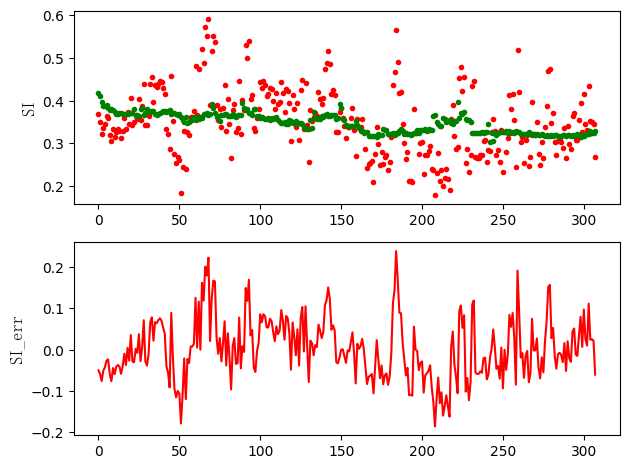

RMSE:  SI: 0.0866
MAPE:  SI: 19.9967% 
MRE :  SI: 0.2000
per :  SI: 0.6970


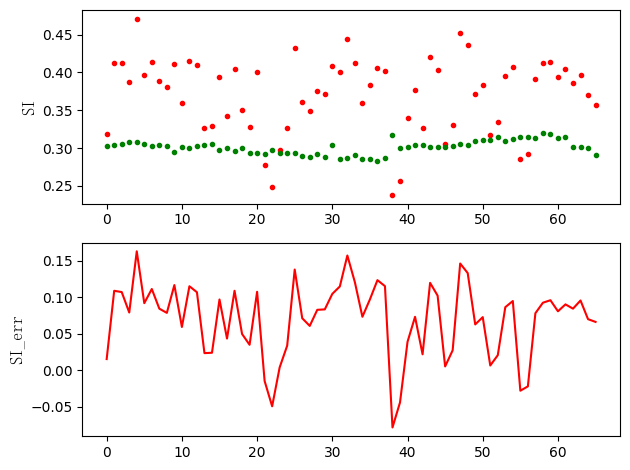

In [99]:
# 高炉模型预测
y_pred_0 = model_.my_predict(X__train)
# 计算 RMSE、MRE
y_test = y__train
# y_test = y_test[:70]
# y_pred_0 = y_pred_0[:70]
# y_pred_1 = y_pred_1[:70]

huahua (scalers,  output_term,y_pred_0,y_test)

# 高炉模型预测
y_pred_0 = model_.my_predict(X__test)
# 计算 RMSE、MRE
y_test = y__test
# y_test = y_test[:70]
# y_pred_0 = y_pred_0[:70]
# y_pred_1 = y_pred_1[:70]

huahua (scalers,  output_term,y_pred_0,y_test)

